In [37]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
# import torch
import numpy as np
import pandas as pd

### Load features and labels

In [4]:
# data = np.load("openl3.npy") 
# data = np.load("openl3_48k.npy")
# features = np.load("resnet.npy") # video
features = np.load("yamnet.npy") # audio
# data = np.load("vgg.npy") # video
features.shape

(25403, 2, 1024)

In [ ]:
#Choose one channel or Compute aveage of the two

In [5]:
features[:1]

array([[[0.15515013, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01888593, 0.        , 0.02607623, ..., 0.607821  ,
         0.        , 0.        ]]], dtype=float32)

In [6]:
features = features.reshape(25403, 2*1024)
features.shape

(25403, 2048)

In [7]:
labels = pd.read_csv("all_labels.csv")
labels.head()

,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation
0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0
1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


### Remove all the data that we have not annotated

In [8]:
filtered_features = []
filtered_labels = []

In [9]:
labels[labels["has_annotation"] == 1].shape

(6346, 13)

In [10]:
for idx, row in labels.iterrows():
    if row["has_annotation"] == 1:
        filtered_features.append(features[idx])
        filtered_labels.append(row)
filtered_labels = pd.DataFrame(filtered_labels).reset_index()
filtered_features = np.array(filtered_features)


In [11]:
filtered_features.shape

(6346, 2048)

In [12]:
filtered_labels.shape

(6346, 14)

## Classify count of all kinds of cars

In [13]:
def get_count_label(num):
    if num == 0:
        return "free"
    if num < 3:
        return "few"
    if num < 6:
        return "medium"
    return "busy"

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
filtered_labels["total_encoder"] = labelencoder.fit_transform(filtered_labels["total"].apply(get_count_label))

enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(filtered_labels[["total_encoder"]]).toarray()

y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [13]:
labelencoder.classes_

array(['busy', 'few', 'free', 'medium'], dtype=object)

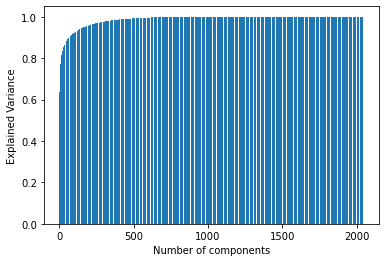

In [15]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
## code here
scaler = preprocessing.StandardScaler().fit(filtered_features)
dataS=scaler.transform(filtered_features)

pca = PCA(dataS.shape[1])
dataP=pca.fit_transform(dataS)
eigenvalues = pca.explained_variance_ratio_

import matplotlib.pyplot as plt
#Plot explained variance per number of leading PC's 
n=2048
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [16]:
dataS.shape

(6346, 2048)

In [17]:
pca=PCA(n_components=128)
dataP=pca.fit_transform(dataS)

In [18]:
dataP.shape

(6346, 128)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(dataP, filtered_labels["total_encoder"], test_size=0.2, random_state=42)

### Random Forest

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 40)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [23]:
random_forest_clf = RandomForestClassifier(random_state=42)

In [31]:
rf_random = RandomizedSearchCV(estimator = random_forest_clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 14, 16, 19, 21,
                                                      23, 26, 28, 30, 33, 35,
                                                      37, 40, 42, 44, 46, 49,
                                                      51, 53, 56, 58, 60, 63,
                                                      65, 67, 70, 72, 74, 76, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [138]:
#generate a dataframe which contains all results
df_ytrain=pd.DataFrame(y_train)
df_ytrain=df_ytrain.reset_index()
train_predict=pd.DataFrame(rf_random.predict(X_train))
encoder_train=pd.merge(df_ytrain,train_predict,left_index=True, right_index=True).set_index('index')

df_yvalid=pd.DataFrame(y_valid).reset_index()
valid_predict=pd.DataFrame(rf_random.predict(X_valid))
encoder_valid=pd.merge(df_yvalid,valid_predict,left_index=True, right_index=True).set_index('index')

allpred_encoder=pd.concat([encoder_train,encoder_valid],axis=0)
new_col = ['total_encoder', 'pred_encoder']
allpred_encoder.columns = new_col
allpred_encoder=allpred_encoder.sort_index(ascending=True)
pred_flabels=pd.merge(filtered_labels,allpred_encoder['pred_encoder'],left_index=True, right_index=True)

pred_flabels['result'] = np.where(pred_flabels['total_encoder']==pred_flabels['pred_encoder'],'True','False')
pred_flabels

,index,Unnamed: 0,file_name,timestamp,car,truck,bicycle,motorbike,bus,total,night,snow,rain,has_annotation,total_encoder,pred_encoder,result
0,0,0,street_traffic-barcelona-161-4901,0.5,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1,1,True
1,1,1,street_traffic-barcelona-161-4901,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
2,2,2,street_traffic-barcelona-161-4901,1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
3,3,3,street_traffic-barcelona-161-4901,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
4,4,4,street_traffic-barcelona-161-4901,2.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,14340,14340,street_traffic-milan-1094-42024,7.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6342,14341,14341,street_traffic-milan-1094-42024,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6343,14342,14342,street_traffic-milan-1094-42024,8.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True
6344,14343,14343,street_traffic-milan-1094-42024,9.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,True


In [130]:
#calculate only valid data accuracy
pred_encoder=encoder_valid

In [131]:
new_col = ['total_encoder', 'pred_encoder']
pred_encoder.columns = new_col

In [132]:
pred_encoder['result'] = np.where(pred_encoder['total_encoder']==pred_encoder['pred_encoder'],'True','False')

In [133]:
pred_encoder

,total_encoder,pred_encoder,result
index,,,
730,0,1,False
5641,1,2,False
5635,1,2,False
4280,1,1,True
217,3,3,True
...,...,...,...
2187,1,1,True
2389,2,1,False
2893,1,1,True


In [134]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_encoder['total_encoder'], pred_encoder['pred_encoder'])

<AxesSubplot:>

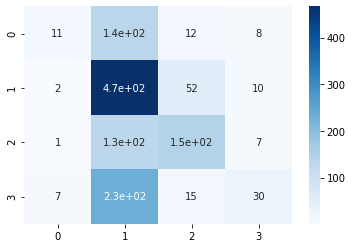

In [135]:
##'busy', 'few', 'free', 'medium'
import seaborn as sn
df_cm = pd.DataFrame(cm) 
sn.heatmap(df_cm,cmap='Blues',annot=True)

<AxesSubplot:ylabel='Frequency'>

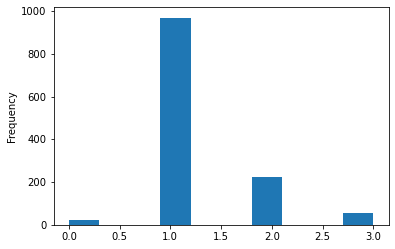

In [136]:
pred_encoder['pred_encoder'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

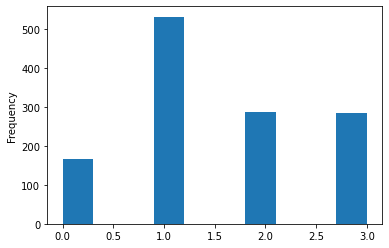

In [137]:
pred_encoder['total_encoder'].plot.hist()

In [139]:
#use same random state to get the valid results
valid_pred=pred_flabels.sample(n=1270,random_state=42)

In [141]:
#Day
dayt=valid_pred[(valid_pred['night']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['night']==0)].shape[0]
#Night
dayf=valid_pred[(valid_pred['night']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['night']==1)].shape[0]
#No Snow
snowf=valid_pred[(valid_pred['snow']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['snow']==0)].shape[0]
#Snow
snowt=valid_pred[(valid_pred['snow']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['snow']==1)].shape[0]
#No Rain
rainf=valid_pred[(valid_pred['rain']==0)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['rain']==0)].shape[0]
#Rain
raint=valid_pred[(valid_pred['rain']==1)&(valid_pred['result']=='True')].shape[0]/valid_pred[(valid_pred['rain']==1)].shape[0]

In [143]:
[dayt,raint,snowt]

[0.5334051724137931, 0.5555555555555556, 0.5419847328244275]

In [144]:
[dayf,rainf,snowf]

[0.4649122807017544, 0.514670896114195, 0.5118525021949079]

In [142]:
import plotly.graph_objs as go
import plotly.offline as py
trace0 = go.Bar(
    x = ['Day','Rain','Snow'],
    y = [dayt,raint,snowt],
    name = 'True',
    marker=dict(
        color = 'rgb(49,130,189)'
    )
)
trace1 = go.Bar(
    x = ['Day','Rain','Snow'],
    y = [dayf,rainf,snowf],
    name = 'False',
    marker=dict(
        color = 'rgb(204,204,204)'
    )
)
data = [trace0,trace1]
py.iplot(data)

In [32]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 93}

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

def evaluate(model, test_features, test_labels, labels):
    print("accuracy:", model.score(test_features, test_labels))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, X_valid, y_valid,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.predict_proba(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()

    return model.score(test_features, test_labels)


accuracy: 0.43622047244094486
[[0.18562874 0.56886228 0.11377246 0.13173653]
 [0.06967985 0.65536723 0.14689266 0.12806026]
 [0.05574913 0.45993031 0.42857143 0.05574913]
 [0.10175439 0.63157895 0.08421053 0.18245614]]


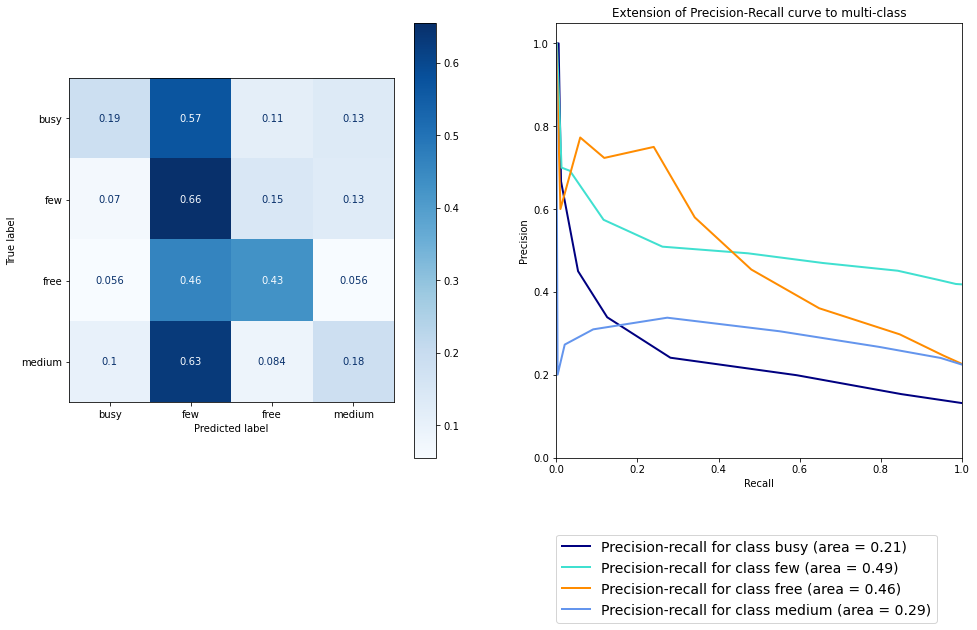

In [34]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_valid, y_valid, labelencoder.classes_)

In [ ]:
#cars passing but not in the view. or the imbalance of the levels
#select files to check, listen the files.

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, best_random.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.52      0.07      0.12       167
           1       0.48      0.88      0.62       531
           2       0.65      0.51      0.57       287
           3       0.55      0.11      0.18       285

    accuracy                           0.51      1270
   macro avg       0.55      0.39      0.37      1270
weighted avg       0.54      0.51      0.44      1270



accuracy: 0.5149606299212598
[[0.06586826 0.81437126 0.07185629 0.04790419]
 [0.00376648 0.87947269 0.09792844 0.01883239]
 [0.00348432 0.46341463 0.5087108  0.02439024]
 [0.0245614  0.81754386 0.05263158 0.10526316]]


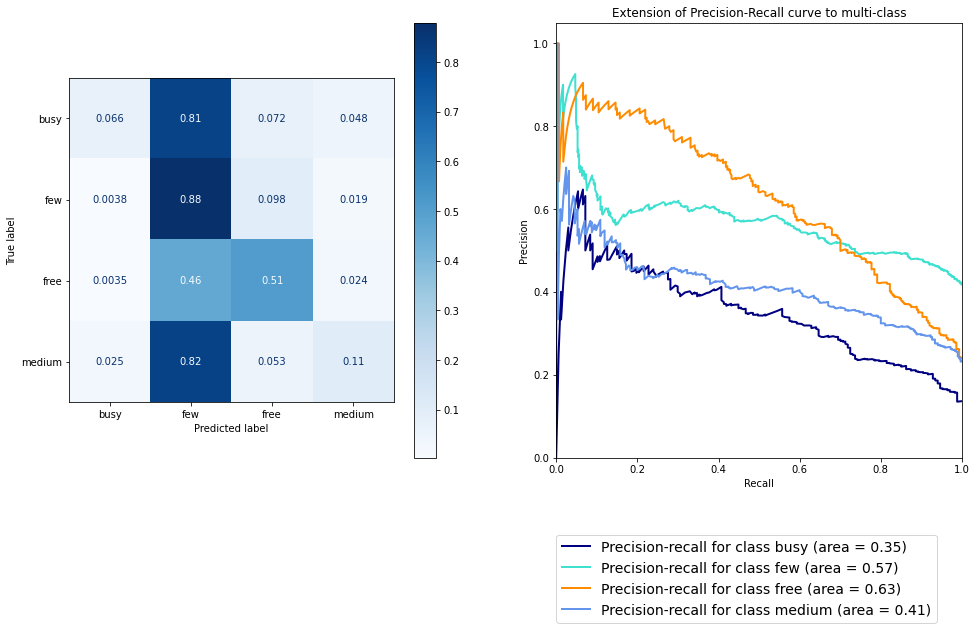

In [35]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, y_valid, labelencoder.classes_)

### SVM

In [28]:
def evaluate_svm(model, test_features, test_labels, labels):
    print("accuracy:", model.score(test_features, test_labels))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    disp = plot_confusion_matrix(model, X_valid, y_valid,
                             display_labels=labelencoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax1)

    print(disp.confusion_matrix)
    
    y_score = model.decision_function(test_features)
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(labels)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(test_labels.apply(lambda x: 1 if x==i else 0),
                                                            y_score[:, i])
    
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

    lines = []
    classes = []
    
    for i, color in zip(range(len(labels)), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        classes.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(labels[i], average_precision[i]))
        

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, classes, loc=(0, -.38), prop=dict(size=14))
    
    plt.show()

    return model.score(test_features, test_labels)

linear
accuracy: 0.5
[[0.29341317 0.60479042 0.08383234 0.01796407]
 [0.05461394 0.78531073 0.14877589 0.01129944]
 [0.03484321 0.40418118 0.53310105 0.02787456]
 [0.10877193 0.77894737 0.05614035 0.05614035]]


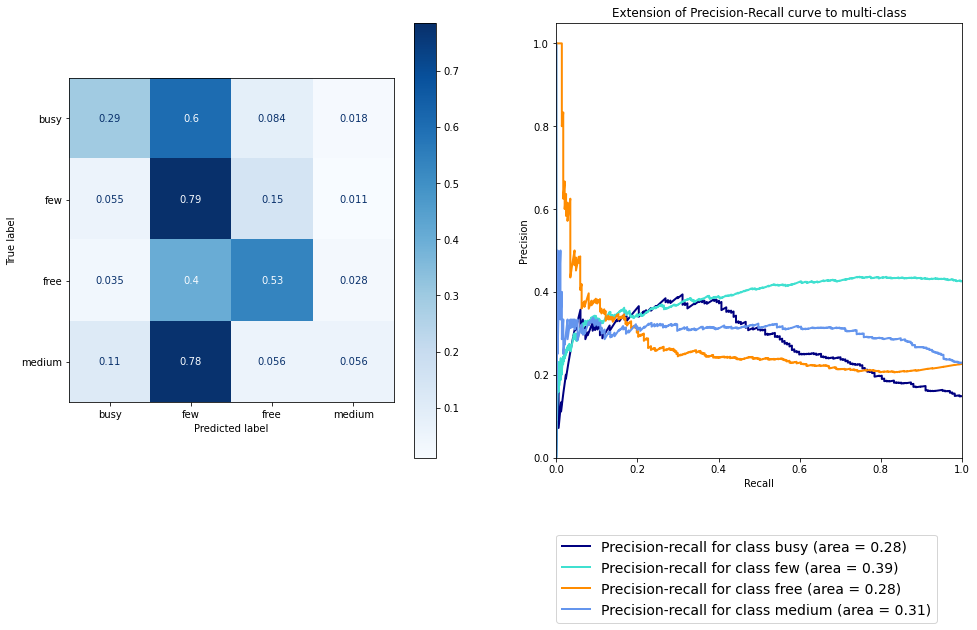

poly
accuracy: 0.4582677165354331
[[0.01197605 0.97005988 0.01197605 0.00598802]
 [0.00376648 0.98305085 0.0094162  0.00376648]
 [0.         0.77351916 0.18118467 0.04529617]
 [0.         0.96140351 0.01754386 0.02105263]]


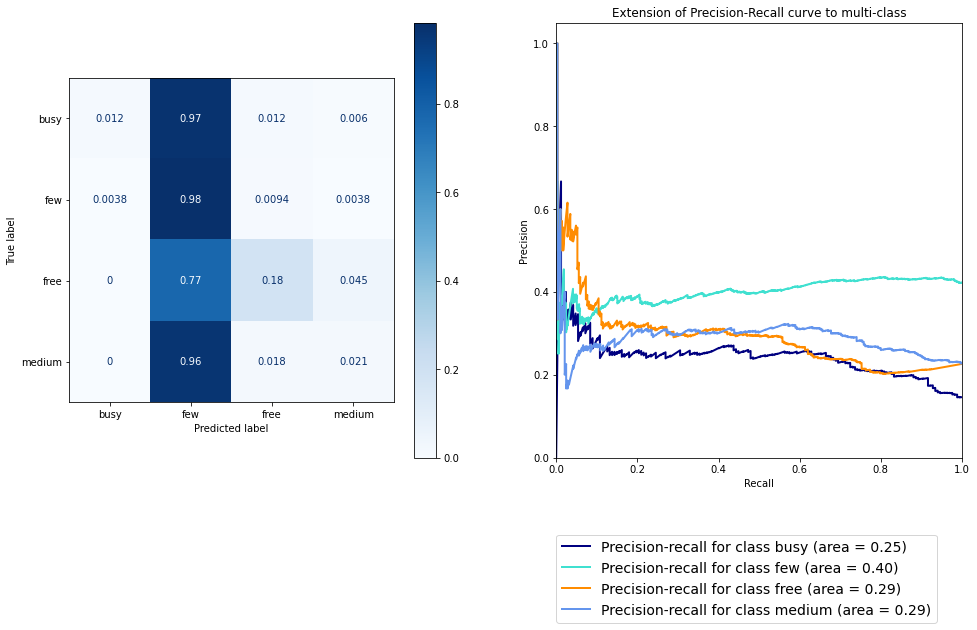

rbf
accuracy: 0.4795275590551181
[[0.00598802 0.85628743 0.13173653 0.00598802]
 [0.         0.87382298 0.12052731 0.00564972]
 [0.         0.50522648 0.4738676  0.02090592]
 [0.00350877 0.9122807  0.05614035 0.02807018]]


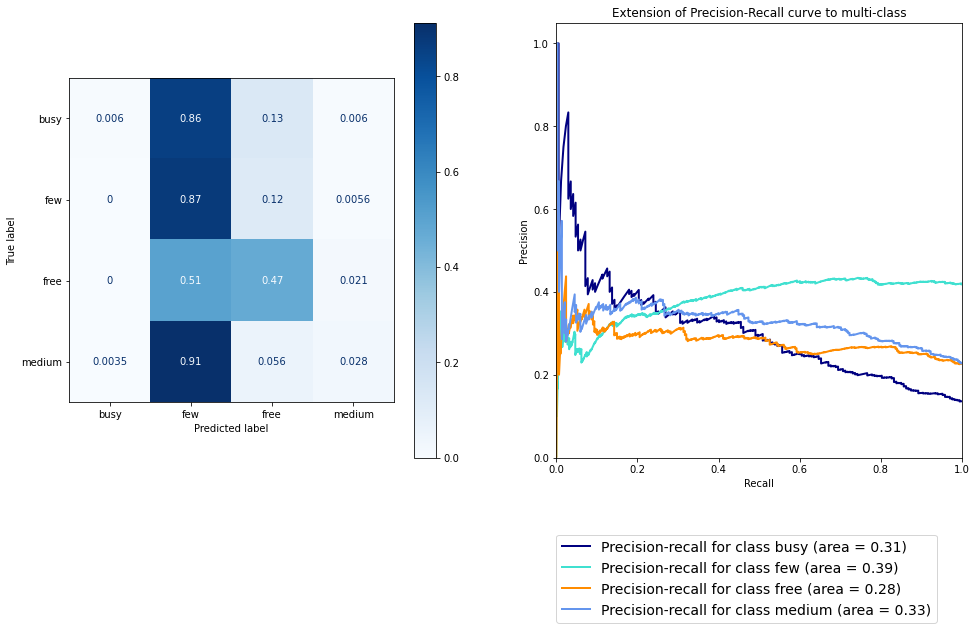

sigmoid
accuracy: 0.4464566929133858
[[0.         0.80838323 0.16766467 0.0239521 ]
 [0.         0.83050847 0.15442561 0.01506591]
 [0.         0.58188153 0.40069686 0.0174216 ]
 [0.         0.87017544 0.09122807 0.03859649]]


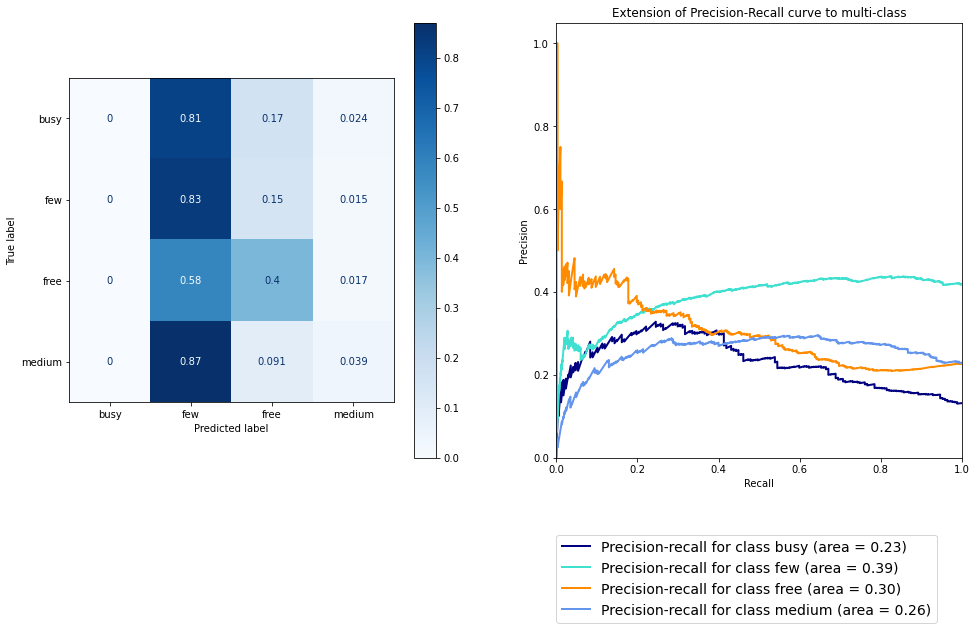

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    print(kernel)
    clf = SVC(kernel=kernel, decision_function_shape="ovo")
    clf.fit(X_train, y_train)
    random_accuracy = evaluate_svm(clf, X_valid, y_valid, labelencoder.classes_)